### Background & Problem Statement

The Algiers Metro is a rapid transit system serving Algiers, the capital of Algeria. The metro has 19 stations and spanning across 18.5 km migrating passengers daily. For this project, we will look at the neighbourhoods surrounding the metro stations and classify them. Some neighbourhoods are mostly residential, others have more business or commercial spaces surrounding them. The venues closest to a station determine why and how people use it. Thus, by analyzing this data we can classify stations by their primary usage. This data is useful for city planners to determine where from and where to people are most likely to travel for work and leisure. This can help plan further extension of the network and find places for new development.

### Data Prep

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scrapy

##### Scraping Algeria metro stations data from Wikipedia

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Algiers_Metro_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')
# get the table containing the postal codes
stations_table = wiki_doc.find('table', {'class': 'wikitable sortable'})

We’ll need data on the location of stations and on the venues closest to them.

In [3]:
indices = [0,3]

stations_df = pd.DataFrame(columns=['Station Name','Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    cells = tr.find_all('td')
    #ignore cells that don't have coordinates
    if cells[3].text.strip() != '':
        stations_df = stations_df.append({
            'Station Name': cells[0].text.strip(),
            'Coordinates': cells[3].find('span', {'class': 'geo'}).text.strip().replace('; ',',')
        }, ignore_index=True)    
        
stations_df.head()
stations_df.to_csv('stations.csv')

In [4]:
#Read csv
stations_df = pd.read_csv('stations.csv', index_col=0)
stations_df

,Station Name,Coordinates
0,Place des Martyrs,"36.78556,3.06222"
1,Ali Boumendjel,"36.77917,3.05806"
2,Tafourah - Grande Poste,"36.77194,3.05806"
3,Khelifa Boukhalfa,"36.76639,3.05361"
4,1er Mai,"36.76056,3.05528"
5,Aïssat Idir,"36.75667,3.05861"
6,Hamma,"36.75306,3.06639"
7,Jardin d'essai,"36.74694,3.07222"
8,Les Fusillés,"36.74222,3.08306"
9,Amirouche,"36.73778,3.09417"


In [5]:
# importing folium library
!conda install -c conda-forge folium=0.5.0 --yes
import folium

# importing Nominatim library
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



### Venues & categories

We will use Foursquare API to explore venue categories surrounding each station. Venues can be categorized as residential, professional, shopping or leisure. Let's see what venue categories Foursquare identifies.

In [6]:
CLIENT_ID = 'FJHUZHQSFDDR2MNUZF3HSD1O2FZKY14UC0RWZL2ZQTSTPVBO' # your Foursquare ID
CLIENT_SECRET = 'QD33X2VJ4KQ0NAEOLUZLDJI1VEXXN2XIGYLB13Y5K2P5A0HU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FJHUZHQSFDDR2MNUZF3HSD1O2FZKY14UC0RWZL2ZQTSTPVBO
CLIENT_SECRET:QD33X2VJ4KQ0NAEOLUZLDJI1VEXXN2XIGYLB13Y5K2P5A0HU


In [7]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [8]:
len(results['response']['categories'])

10

In [9]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


### Methodology

We can use the foursquare explore API with categoryId to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [10]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [11]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [12]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [13]:
#Read already stored CSV
stations_venues_df = pd.read_csv('stations_venues.csv', index_col=0)
stations_venues_df

,Station Name,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Place des Martyrs,"36.78556,3.06222",5,1,0,3,0,4,6,1,3,4
1,Ali Boumendjel,"36.77917,3.05806",3,3,0,10,2,3,4,1,6,5
2,Tafourah - Grande Poste,"36.77194,3.05806",4,3,0,12,2,3,3,0,11,6
3,Khelifa Boukhalfa,"36.76639,3.05361",4,4,0,9,7,2,4,2,13,6
4,1er Mai,"36.76056,3.05528",4,4,0,6,6,4,4,2,10,5
5,Aïssat Idir,"36.75667,3.05861",1,2,0,5,1,2,4,2,7,4
6,Hamma,"36.75306,3.06639",3,1,0,4,1,5,6,2,1,5
7,Jardin d'essai,"36.74694,3.07222",6,0,0,10,4,5,3,0,0,4
8,Les Fusillés,"36.74222,3.08306",3,0,0,5,2,3,5,1,0,5
9,Amirouche,"36.73778,3.09417",0,0,0,7,0,1,9,1,5,5


### Exploratory analysis & basic cleanup

Display the number of venues as boxplots (showing the average count, spread and outliers).

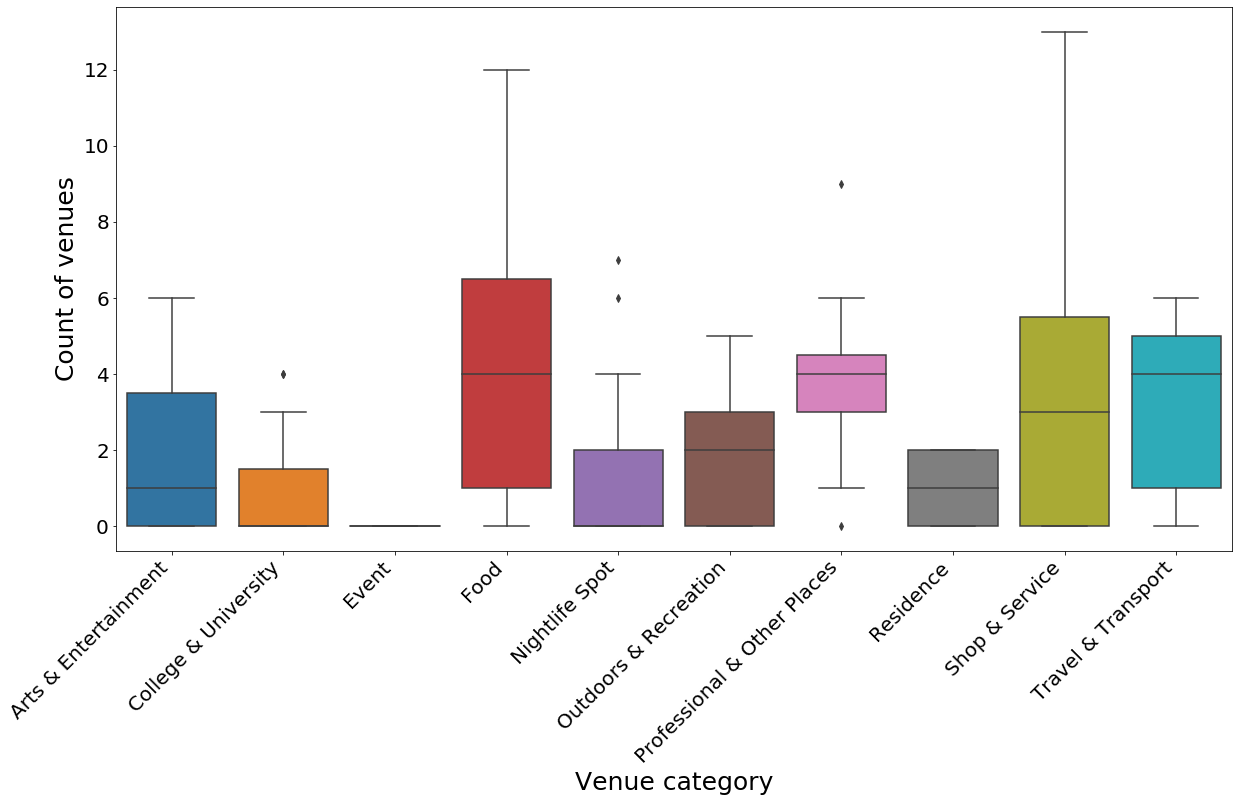

In [14]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

The most frequent venue categories are Food, Shop & Service. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [15]:
stations_venues_df.drop('Event', 1, inplace=True)

In [16]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

### Data Prep for normalization

Let’s normalize the data using min-max scaling (scale count of venues from 0 to 1 where 0 is the lowest value in a set and 1 is highest). This both normalizes the data and provides an easy to interpret score at the same time. 

In [17]:
from sklearn.preprocessing import MinMaxScaler
X = stations_venues_df.values[:,2:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [18]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.833333,0.25,0.250000,0.000000,0.8,0.666667,0.5,0.230769,0.666667
1,0.500000,0.75,0.833333,0.285714,0.6,0.444444,0.5,0.461538,0.833333
2,0.666667,0.75,1.000000,0.285714,0.6,0.333333,0.0,0.846154,1.000000
3,0.666667,1.00,0.750000,1.000000,0.4,0.444444,1.0,1.000000,1.000000
4,0.666667,1.00,0.500000,0.857143,0.8,0.444444,1.0,0.769231,0.833333


Visualize the scaled data

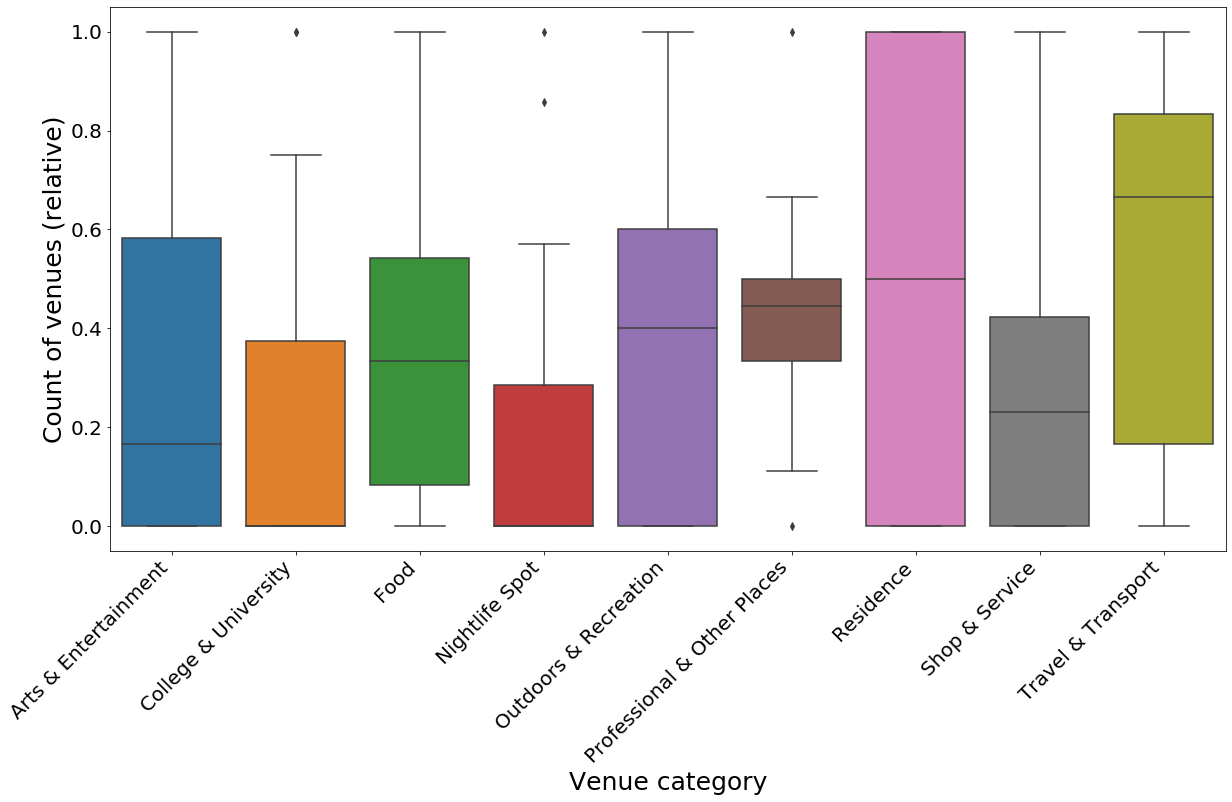

In [19]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

### Clustering

Using k-means clustering.

These were preliminary results with different number of clusters:

K=2 clusters dont identify neighborhoods clearly

K=4 clusters identify neighborhoods with low number of venues

K=5 and more clusters are difficult to interpret

For the final analysis let's settle on 4 clusters.

In [20]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Station Name'] = stations_df['Station Name']
stations_clusters_minmax_df['Coordinates'] = stations_df['Coordinates']

Visualize the clusters with boxplots

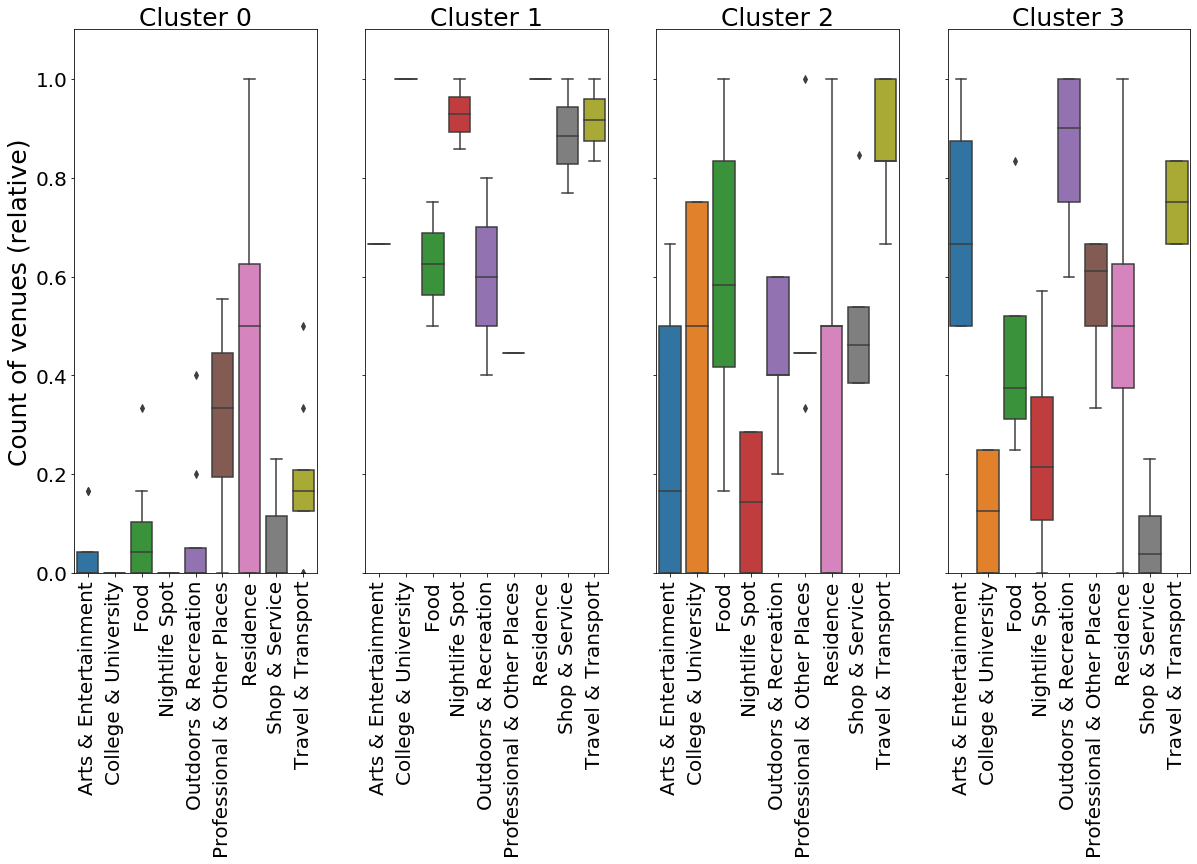

In [21]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Map the data. For each station we'll display top 3 venue categories.

In [33]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[28.0339, 1.6596], zoom_start=5)

# set color scheme for the clusters
colors=['blue','green','orange','red']

# add markers to the map
markers_colors = []
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['Station Name'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')] 
    
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)

    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
       
       
    folium.CircleMarker(
        latlong,
        radius=5,
        popup=folium.Popup(str(popup), max_width = 300, parse_html=True),
        color=colors[cluster],
        fill=True,
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters


In [34]:
map_clusters.save('map12.html')

### Results & Discussion

Here is how we can characterize the clusters by looking at venue scores:

Cluster 0 (Blue) scores high on Residence, Professional & other places. This appears to be residential area as well as business part of the city.
Cluster 1 (Green) scores high on nightlife, shops & services and travel & transport. 
Cluster 2 (Orange) scores high on collge & university, food and travel & transport. This appears to be the student hub of the city.
Cluster 3 (Red) scores high on outdoor & recreational and art & entertainment. 

Plotting the clusters on a map shows us that:

Most of the stations are located along the coastal line which appears to be old and developed part of the city. 
Cluster 0 is the most inside of the coastal line than other clusters indicating it as primary upcoming areas for residental and business development. The highest number of veneues are in the Food and Shop & Service categories.

The clustering in this analysis has been done basis distance of the veneues from stations, but there are other aspects such as footfall in veneues, common veneues around stations which have not been considered here therefore this analysis is not conclusory. Furthermore, the results could also potentially vary if we use some other clustering techniques like DBSCAN.

### Conclusion

Finally, to conclude this project we can say that Foursquare data has certainly given some preliminary information and brief insight into city’ development. This data can be combined with other sources to provide more accurate results.